In [1]:
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
## run this first!

library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(cowplot)

options(repr.matrix.max.rows=10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Final Project: Optimized Classifier: Assessment of Regional Predictor Differences and Influence on Heart Disease Diagnoses  

### Introduction
The heart disease data includes datasets from Cleveland, California, Budapest, and Zurich. We will focus on Cleveland and Budapest because it is the most complete. Out of the 14 variables, 9 are categorical variables, variables that we can potentially predict by building a classifier.  

However, fasting blood pressure (fbs),  resting electrocardiographic results (restecg), the slope of the peak exercise ST segment (slope), number of major vessels (ca), reversible defect (thal) are objectively measured values and would be simpler to measure than predict.  

Predicting sex (sex) based on heart predictors diverges from the topic and could raise moral and ethical issues. Building a classifier to predict Chest pain type is not benefitial to the healthcare system, more on this through data visualizations in chest pain type frequency in Cleveland and Hungary bar plots.

CT scans to see potential blockages in arteries as a method of preventative care are avoided by public healthcare systems or costly with private healthcare. An accurate predictor could serve as a cheaper and more efficient alternative. There’s a dearth in understanding of whether optimal accuracy is achieved by building individual classifiers per region or by accumulating a large training set.

Preliminarily, numerical indicators include age, resting blood pressure(trestbps), serum cholesterol levels (chol), maximum heart rate achieved (thalach), and ST depression induced by exercise relative to rest (oldpeak).

We will aim to answer the following research question using numerical predictors:

1. Are all numerical predictors relevant to building an optimally accurate classifier? If not, which ones should we remove?

Also briefly touch upon this one in exploratory analysis.

2. How does the frequency distribution of predictors change in Cleveland versus Hungary datasets?  

## Preliminary Exploratory Data Analysis
### Reading, Tidying, and Wrangling Data

Firstly, we read two datasets(processed.cleveland.data & reprocessed.hungarian.data) directly from the web, gave every column a specific header name, selected the columns we are interested in, and converted every column into the correct and most appropriate data type. Then, all of the datasets are in a tidy format. 

Secondly, we split every dataset into a training set and a testing set with strata = num, ensuring that roughly the same proportion of 0 and 1(0 means no diagnosis; 1 means diagnosed) ends up in both training and testing sets. In the following steps, we will only analyze, summarize, and visualize the training sets of the two datasets.

In [3]:
set.seed(18)
con_names1<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang", "oldpeak","slope","ca","thal","num")
heart_cleveland<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                           col_names = con_names1)

cleveland_mutate<-heart_cleveland|>
filter(num==0|num==1)|>
select(age,sex,cp,trestbps,chol,thalach,oldpeak,num)|>
mutate(age=as.integer(age))|>
mutate(num=as.factor(num))|>
mutate(cp=as.factor(cp))|>
mutate(sex=as.factor(sex))|>
mutate(trestbps=as.double(trestbps))|>
mutate(thalach=as.double(thalach))|>
mutate(oldpeak=as.double(oldpeak))

cleveland_split <- initial_split(cleveland_mutate, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

cleveland_training #print training data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,thalach,oldpeak,num
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,150,2.3,0
37,1,3,130,250,187,3.5,0
41,0,2,130,204,172,1.4,0
56,1,2,120,236,178,0.8,0
57,0,4,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
67,1,3,152,212,150,0.8,1
63,0,4,124,197,136,0.0,1
57,0,4,140,241,123,0.2,1


In [4]:
summary <- cleveland_mutate|>
summarize(n= sum(num==1))/nrow(cleveland_mutate)

summary


n
<dbl>
0.2511416


In [5]:
set.seed(18)
heart_hungarian <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data",delim=" ", 
                              col_names = con_names1)
hungarian_mutate <- heart_hungarian|>
filter(num==0|num==1)|>
select(age,sex,cp,trestbps,chol,thalach,oldpeak,num)|>
mutate(age=as.integer(age))|>
mutate(num=as.factor(num))|>
mutate(cp=as.factor(cp))|>
mutate(sex=as.factor(sex))|>
mutate(trestbps=as.double(trestbps))|>
mutate(thalach=as.double(thalach))|>
mutate(oldpeak=as.double(oldpeak))



hungarian_split <- initial_split(hungarian_mutate, prop = 0.75, strata = num)
hungarian_training <- training(hungarian_split)
hungarian_testing <- testing(hungarian_split)

hungarian_training #print training data


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,thalach,oldpeak,num
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,1,2,140,289,172,0,0
37,1,2,130,283,98,0,0
54,1,3,150,-9,122,0,0
39,1,3,120,339,170,0,0
45,0,2,130,237,170,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
50,1,4,145,264,150,0.0,1
38,1,4,92,117,134,2.5,1
48,1,4,160,268,103,1.0,1


-------------------------------------------------------------------------------------------------------------------------------

### Summary of the five potential numerical variables for the two heart disease training datasets from Cleveland and Hungarian.

We summarized the five potential numerical predictors(age, trestbps, chol, thalach, & oldpeak). We obtained the means, maximums, and minimums formatted via tables. Each training dataset has two tables: one is summarized based on the whole dataset, and another one is summarized based on only individuals with heart disease, where num=1.

In [6]:
#Cleveland Summary for all individuals (max, min, mean)
cleveland_5predictors_all_summary<-summarize(cleveland_training,
                                        age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))
#Cleveland Summary for diagnosed individuals (max, min, mean)
cleveland_5predictors_diagnosed_summary<-summarize(cleveland_training|>filter(num==1),
                                        age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))

In [7]:
#Hungary Summary for all individuals (max, min, mean)
hungarian_5predictors_all_summary<-summarize(hungarian_training,
                                       age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))

#Hungary Summary for diagnosed individuals (max, min, mean)
hungarian_5predictors_diagnosed_summary<-summarize(hungarian_training|>filter(num==1),
                                      age_max=max(age,na.rm=TRUE),
                                        age_min=min(age,na.rm=TRUE),
                                        age_mean=mean(age,na.rm=TRUE),
                                        trestbps_max=max(trestbps,na.rm=TRUE),
                                        trestbps_min=min(trestbps,na.rm=TRUE),
                                        trestbps_mean=mean(trestbps,na.rm=TRUE),
                                        chol_max=max(chol,na.rm=TRUE),
                                        chol_min=min(chol,na.rm=TRUE),
                                        chol_mean=mean(chol,na.rm=TRUE),
                                        thalach_max=max(thalach,na.rm=TRUE),
                                        thalach_min=min(thalach,na.rm=TRUE),
                                        thalach_mean=mean(thalach,na.rm=TRUE),
                                        oldpeak_max=max(oldpeak,na.rm=TRUE),
                                        oldpeak_min=min(oldpeak,na.rm=TRUE),
                                        oldpeak_mean=mean(oldpeak,na.rm=TRUE))

## Methods
 
(.......Building on the methodology touched upon in the introduction and visualization, and we will do these in the following steps:

1. Building classifiers with optimal accuracy using v=5 cross-validation.
a. Per city ( Budapest (in Hungary), Cleveland, might add more cities to solidify conclusion) 
b. The large classifier with Budapest (in Hungary) and Cleveland with all predictors, and 1 for each predictor.

2. Compare the v=5 cross-folded accuracy of the different classifiers. Assess if changes hindered or benefited the classifier. 
3. Look at how predictors have changed across regions and assess if a region-specific classifier or a cumulative training set classifier is more accurate.
)


In [8]:
cleveland_training

age,sex,cp,trestbps,chol,thalach,oldpeak,num
<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,150,2.3,0
37,1,3,130,250,187,3.5,0
41,0,2,130,204,172,1.4,0
56,1,2,120,236,178,0.8,0
57,0,4,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
67,1,3,152,212,150,0.8,1
63,0,4,124,197,136,0.0,1
57,0,4,140,241,123,0.2,1


In [9]:
#Code Source: ...

set.seed(18)
#select 5 numerical variables from the cleveland training dataset
cleveland_training_subset <- cleveland_training |> 
  select(age, 
         trestbps, 
         chol, 
         thalach, 
         oldpeak, 
         num)

cleveland_testing_subset <- cleveland_testing |> 
  select(age, 
         trestbps, 
         chol, 
         thalach, 
         oldpeak, 
         num)
#extract variable names from the cleveland training sub dataset
names <- colnames(cleveland_training_subset |> select(-num))

names

cleveland_training_subset
cleveland_testing_subset

[1] "age"      "trestbps" "chol"     "thalach"  "oldpeak"

age,trestbps,chol,thalach,oldpeak,num
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
37,130,250,187,3.5,0
41,130,204,172,1.4,0
56,120,236,178,0.8,0
57,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮
67,152,212,150,0.8,1
63,124,197,136,0.0,1
57,140,241,123,0.2,1


age,trestbps,chol,thalach,oldpeak,num
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,140,203,155,3.1,1
57,140,192,148,0.4,0
56,140,294,153,1.3,0
64,110,211,144,1.8,0
58,120,340,172,0.0,0
⋮,⋮,⋮,⋮,⋮,⋮
66,160,228,138,2.3,0
71,112,149,125,1.6,0
66,146,278,152,0.0,0


In [10]:
heaartdisease<-cleveland_training_subset|>
group_by(num)|>
summarize(n=n())

heaartdisease

num,n
<fct>,<int>
0,123
1,41


Data here is un...

In [11]:
ups_recipe <- recipe(num~., data = cleveland_training_subset)|>
step_upsample(num, over_ratio = 1, skip = FALSE)|>
prep()

upsampled_cleveland_training_subset <- bake(ups_recipe, cleveland_training_subset)

unsampled_heaartdisease<-upsampled_cleveland_training_subset|>
group_by(num)|>
summarize(n=n())


upsampled_cleveland_training_subset

age,trestbps,chol,thalach,oldpeak,num
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
37,130,250,187,3.5,0
41,130,204,172,1.4,0
56,120,236,178,0.8,0
57,120,354,163,0.6,0
⋮,⋮,⋮,⋮,⋮,⋮
59,134,204,162,0.8,1
44,110,197,177,0.0,1
57,150,276,112,0.6,1


In [12]:
set.seed(18)
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heartdisease_vfold <- vfold_cv(upsampled_cleveland_training_subset, v = 5, strata = num)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("num", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        hd_recipe <- recipe(as.formula(model_string), 
                                data = upsampled_cleveland_training_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
        
            # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heartdisease_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy")|>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()


        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
        
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies    

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ age,0.7231667
2,num ~ age+chol,0.8290000
3,num ~ age+chol+oldpeak,0.8375000
4,num ~ age+chol+oldpeak+trestbps,0.8583333
5,num ~ age+chol+oldpeak+trestbps+thalach,0.8418333


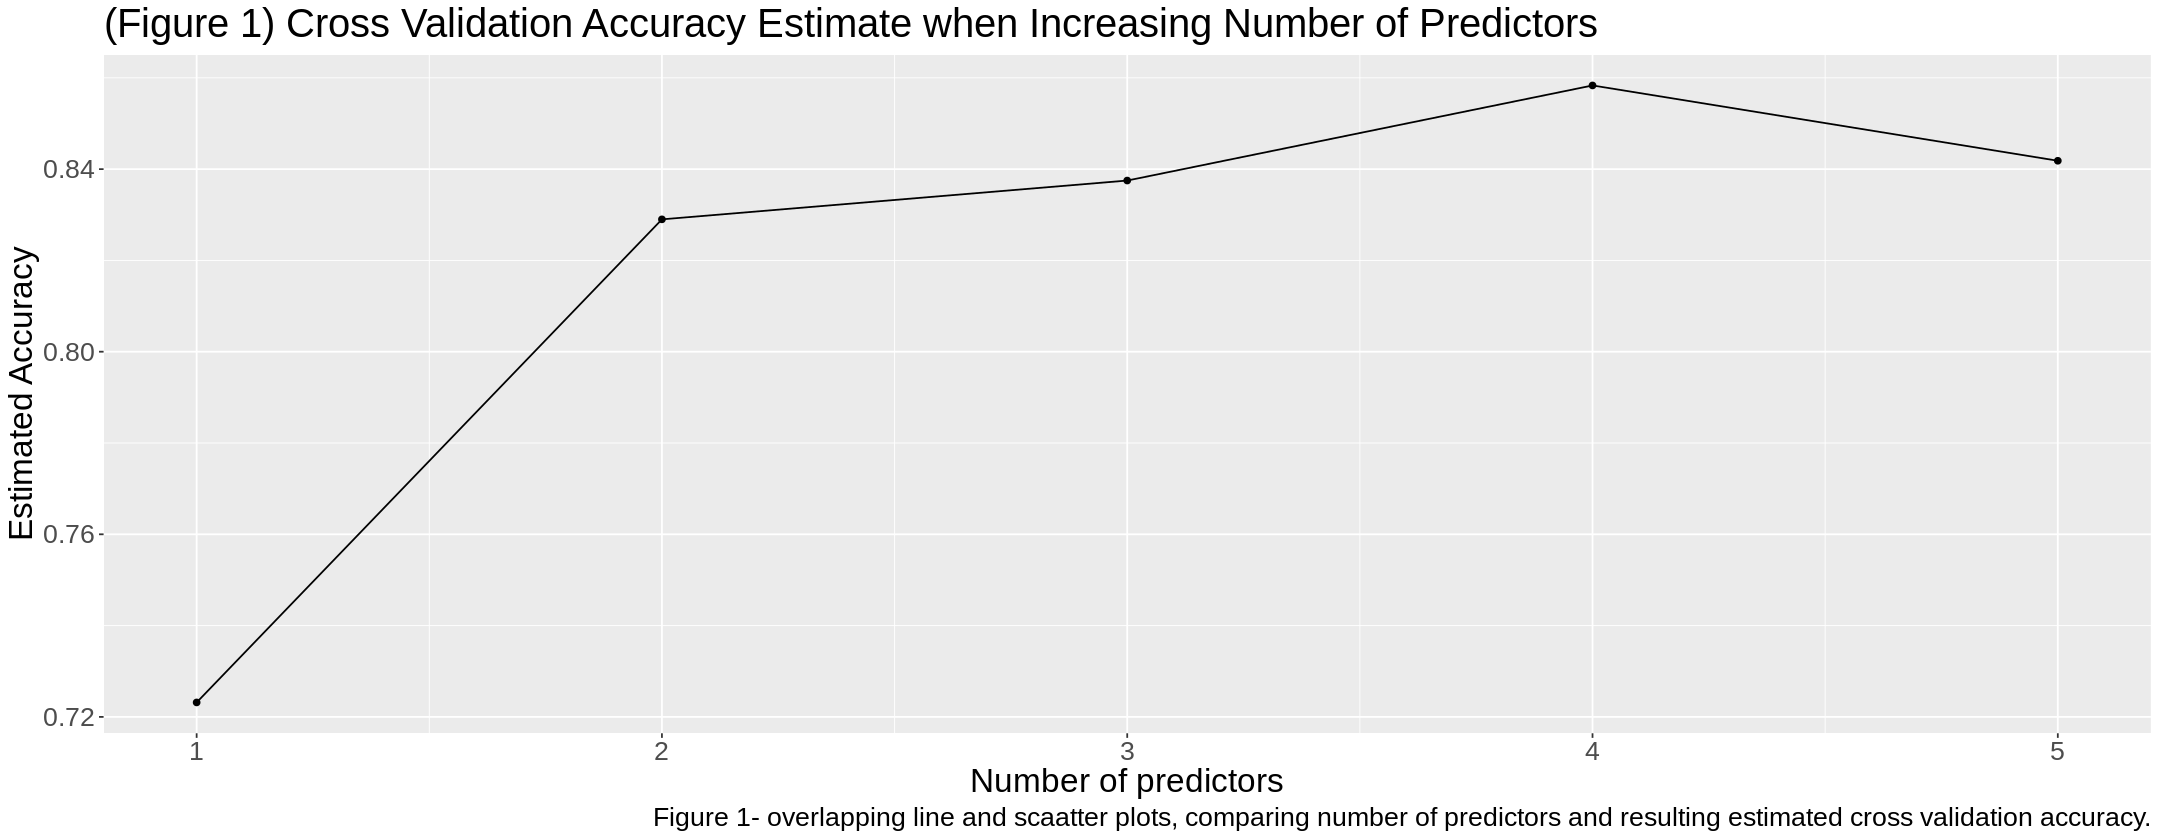

In [13]:
options(repr.plot.width=18, repr.plot.height=7)
accuracies_corss_validation_plot<-accuracies|>
ggplot(aes(x=size,y=accuracy))+
geom_point()+
geom_line()+
labs(x="Number of predictors",y="Estimated Accuracy",
     caption ="Figure 1- overlapping line and scaatter plots, comparing number of predictors and resulting estimated cross validation accuracy.")+
theme(text=element_text(size=20))+
ggtitle("(Figure 1) Cross Validation Accuracy Estimate when Increasing Number of Predictors")


accuracies_corss_validation_plot

In [16]:
set.seed(18)
#test the five classifiers on the testing dataset

heartDisease_vfold <- vfold_cv(upsampled_cleveland_training_subset, v = 5, strata = num)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
#neighbors vs cross vaalidation accuracy

recipe_size1 <- recipe(num ~ trestbps, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size1 <- workflow() |>
  add_recipe(recipe_size1) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size1 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size1) |>
         set_engine("kknn") |>
         set_mode("classification")


accuracy_testing_dataset_size1 <- workflow() |>
         add_recipe(recipe_size1) |>
         add_model(best_spec_size1) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)
          


recipe_size2 <- recipe(num ~ trestbps+age, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size2 <- workflow() |>
  add_recipe(recipe_size2) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size2) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size2 <- workflow() |>
         add_recipe(recipe_size2) |>
         add_model(best_spec_size2) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)


recipe_size3 <- recipe(num ~ trestbps+age+oldpeak, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size3 <- workflow() |>
  add_recipe(recipe_size3) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size3 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size3) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size3 <- workflow() |>
         add_recipe(recipe_size3) |>
         add_model(best_spec_size3) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)

recipe_size4 <- recipe(num ~ trestbps+age+oldpeak+chol, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size4 <- workflow() |>
  add_recipe(recipe_size4) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size4 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size4) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size4 <- workflow() |>
         add_recipe(recipe_size4) |>
         add_model(best_spec_size4) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)


recipe_size5 <- recipe(num ~ trestbps+age+oldpeak+chol+thalach, data = upsampled_cleveland_training_subset) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

best_k_size5 <- workflow() |>
  add_recipe(recipe_size5) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heartDisease_vfold, grid = 10) |>
  collect_metrics()|>
  filter(.metric == "accuracy")|>
  arrange(desc(mean))|>
  head(1)|>
  pull(neighbors)

best_spec_size5 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_size5) |>
         set_engine("kknn") |>
         set_mode("classification")

accuracy_testing_dataset_size5 <- workflow() |>
         add_recipe(recipe_size5) |>
         add_model(best_spec_size5) |>
         fit(data = upsampled_cleveland_training_subset)|>
          predict(cleveland_testing_subset) |>
          bind_cols(cleveland_testing_subset) |>
          metrics(truth = num, estimate = .pred_class)|>
          filter(.metric == "accuracy")|>
          pull(.estimate)
###

accuracy_testing_dataset_size1
accuracy_testing_dataset_size2
accuracy_testing_dataset_size3
accuracy_testing_dataset_size4
accuracy_testing_dataset_size5

[1] 15

[1] 2

[1] 0.6

[1] 0.5090909

[1] 0.6

[1] 0.6727273

[1] 0.6545455

In [53]:
size<-list(1, 2, 3, 4, 5)
model_string<-list("num ~ age", "num ~ age+chol",
                   "num ~ age+chol+oldpeak",
                   "num ~ age+chol+oldpeak+trestbps",
                   "num ~ age+chol+oldpeak+trestbps+thalach")
accuracy <- list(accuracy_testing_dataset_size1,
accuracy_testing_dataset_size2,
accuracy_testing_dataset_size3,
accuracy_testing_dataset_size4,
accuracy_testing_dataset_size5)



testing_accuracies<-tibble(size|>unlist(), model_string|>unlist(), accuracy|>unlist())|>
rename(size="unlist(size)", model_string="unlist(model_string)",accuracy="unlist(accuracy)")
col_names <- c("size", "model_string", "accuracy")

testing_accuracies



size,model_string,accuracy
<dbl>,<chr>,<dbl>
1,num ~ age,0.6000000
2,num ~ age+chol,0.5090909
3,num ~ age+chol+oldpeak,0.6000000
4,num ~ age+chol+oldpeak+trestbps,0.6727273
5,num ~ age+chol+oldpeak+trestbps+thalach,0.6545455


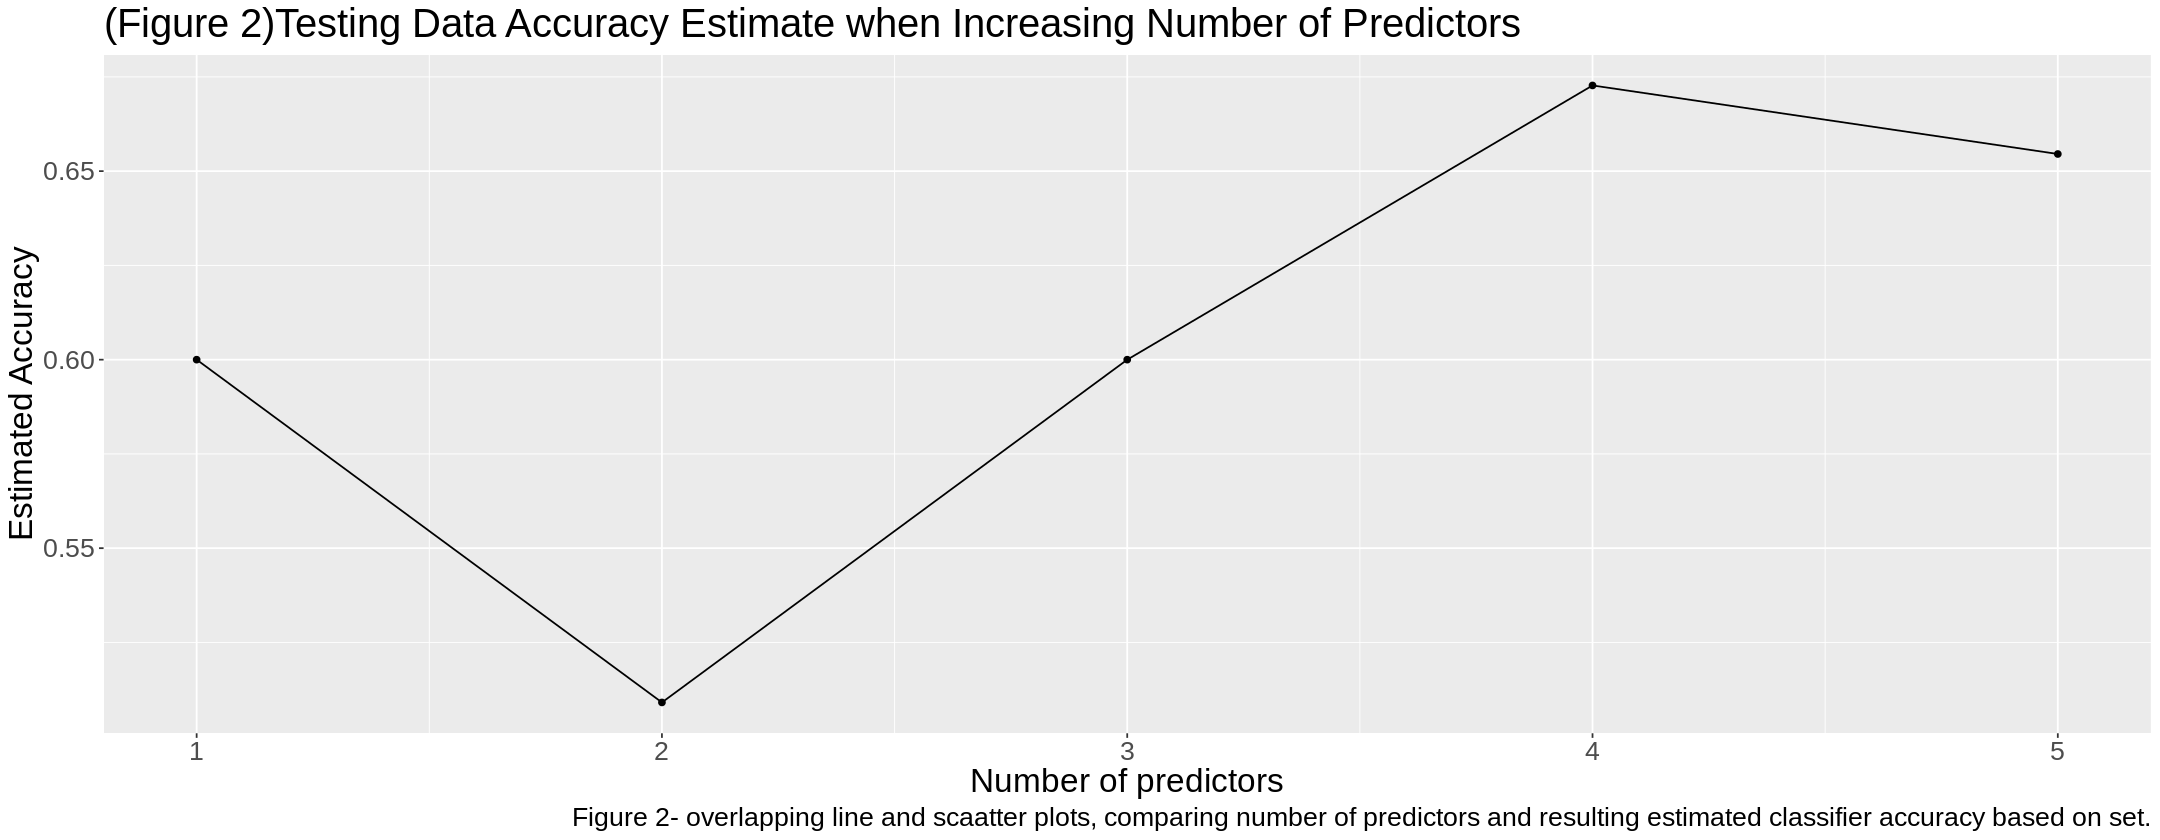

In [54]:
options(repr.plot.width=18, repr.plot.height=7)
accuracies_testing_data_plot<-testing_accuracies|>
ggplot(aes(x=size,y=accuracy))+
geom_point()+
geom_line()+
labs(x="Number of predictors",y="Estimated Accuracy",
     caption ="Figure 2- overlapping line and scaatter plots, comparing number of predictors and resulting estimated classifier accuracy based on set.")+
theme(text=element_text(size=20))+
ggtitle("(Figure 2)Testing Data Accuracy Estimate when Increasing Number of Predictors")


accuracies_testing_data_plot

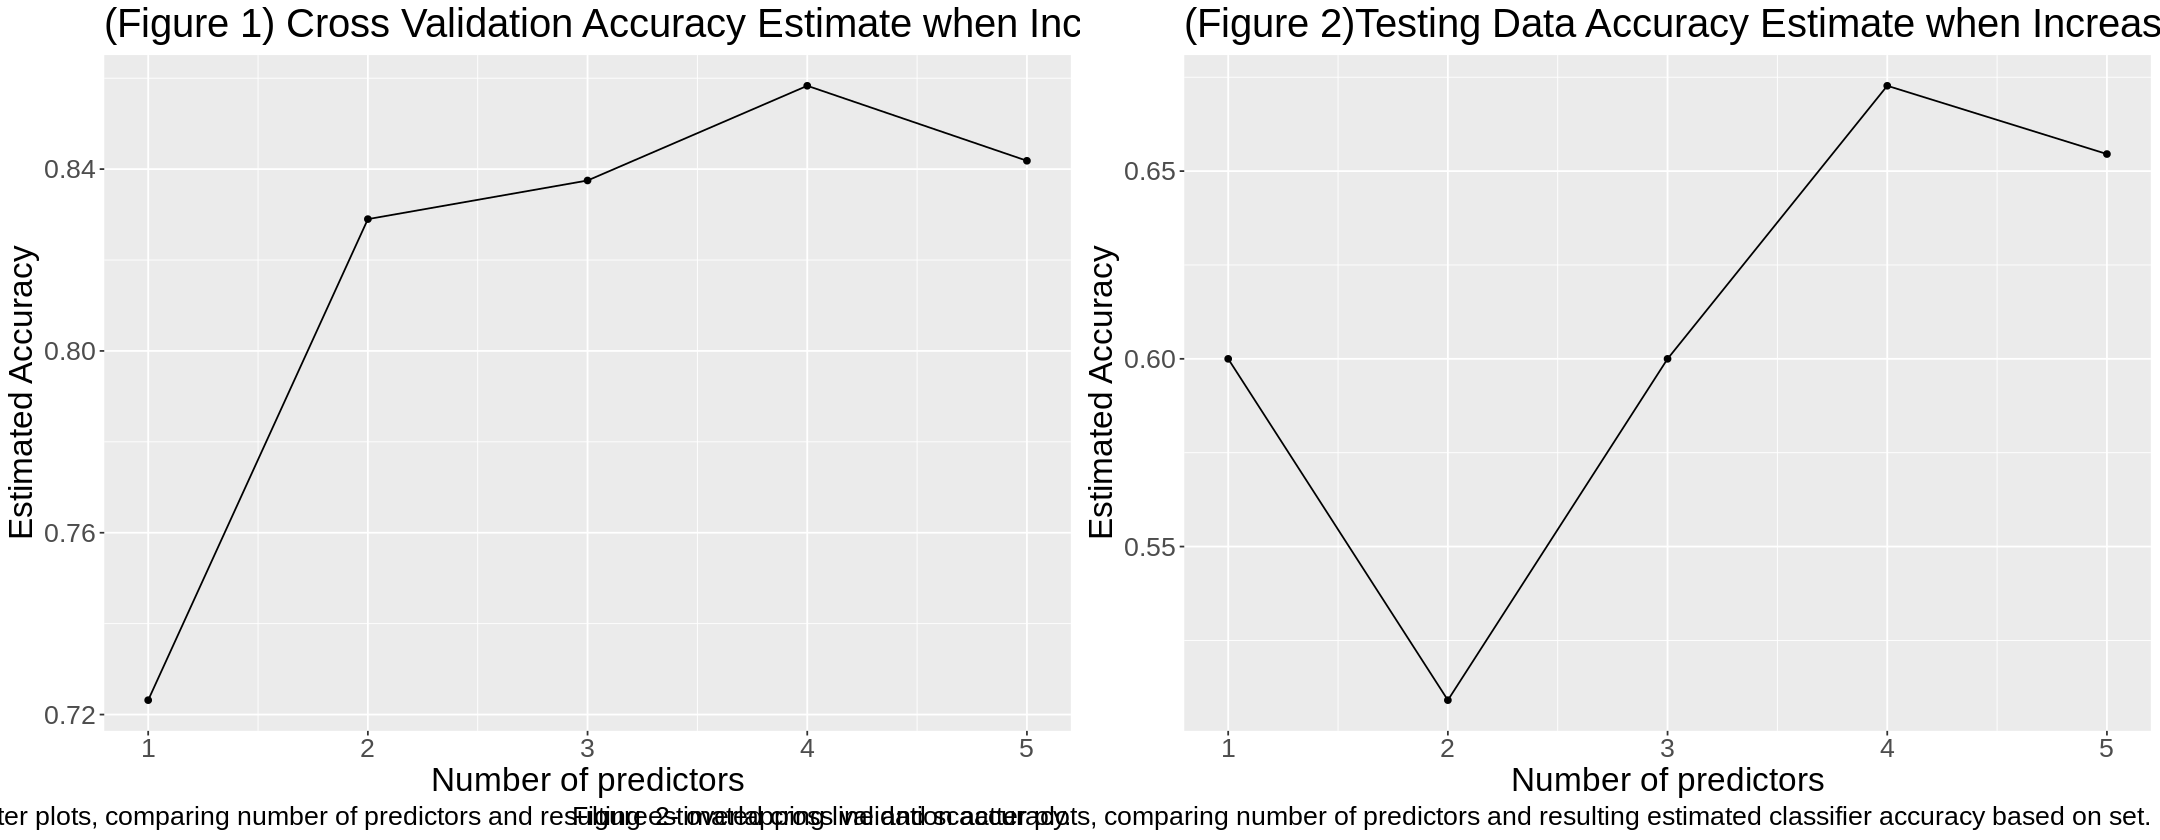

In [55]:
plot_grid(accuracies_corss_validation_plot, accuracies_testing_data_plot, ncol = 2)

## Expected outcomes and significance:
### What do you expect to find?
It is expected that different regions will have different predictors predicting if new observations are diagnosed with heart disease or not. We hypothesize that classifiers should be region specific to optimize accuracy. On top of numerical predictors, which we found to be appropriate, sex also could be a relevant predictor.

### What impact could such findings have?
An accurate classifier could ease the healthcare system and improve efficiency by distributing healthcare personnel to more urgent situations. It could also create a cheaper alternative for government and private healthcare systems.

### What future questions could this lead to?

More research can be produced in reagrds to whether if numerical predictions lead to different diagnoses in different regions and if it would be more beneficial to build a classifier per region or one giant classifier (via classifier accuracy analysis)?

Preliminary data already indicated that a higher maximum heart rate leads to lower chances of heart disease. Methods to maximize heart rate could be a research question that aids preventative care. With more healthy individuals, there will be a less exhausted healthcare system. #() 

Finally, more data could be collected on if external factors such as environmental, economical, political, and social could affect current predictors in this classifier.





